## Debido a que la documentacion explicita y detallada del código no es una norma que se ha exigido, documentaré este codigo a modo de ser lo más detallado posible sin tardarme más de una hora en hacerlo (si era así)

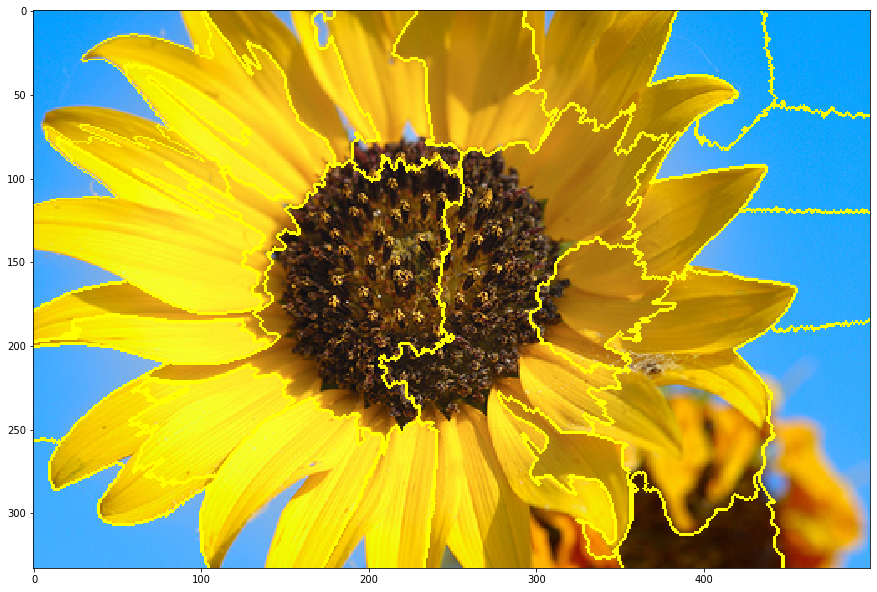

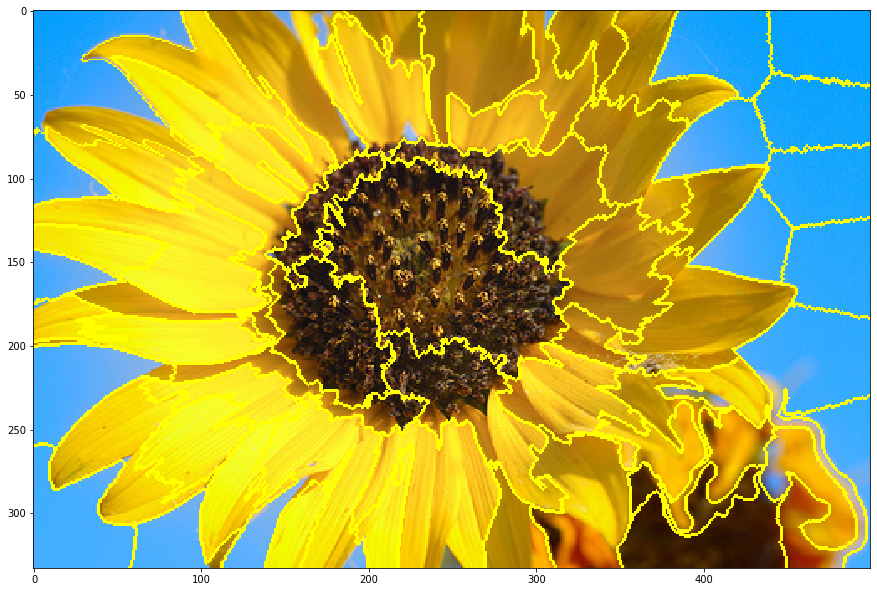

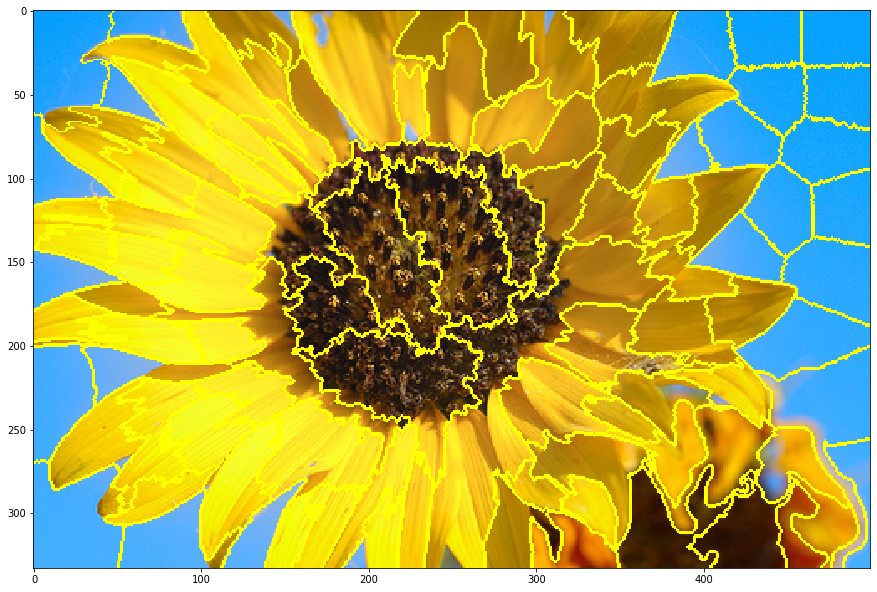

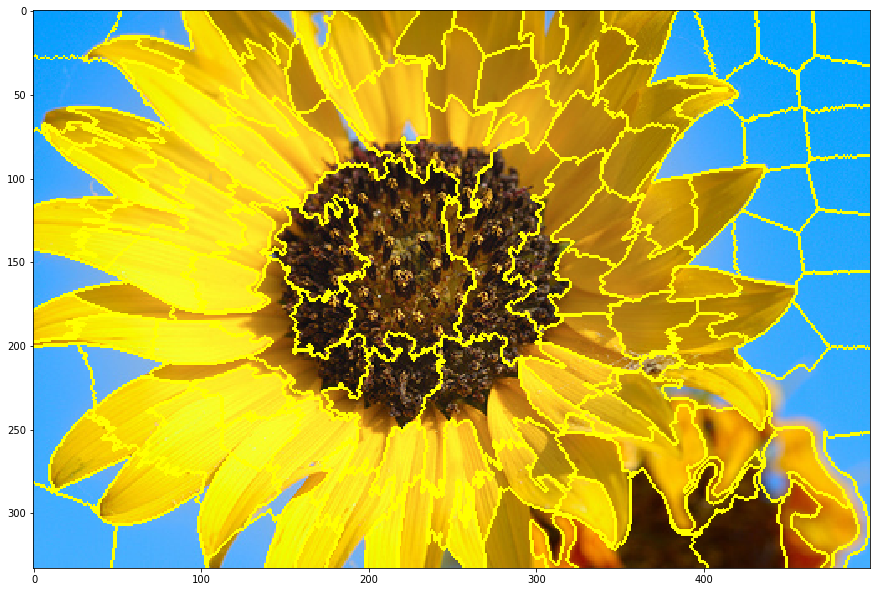

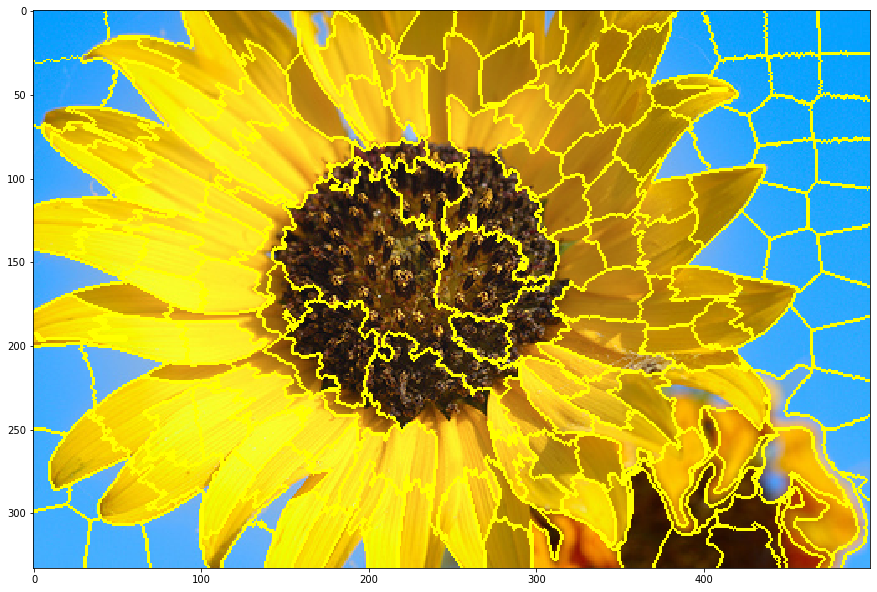

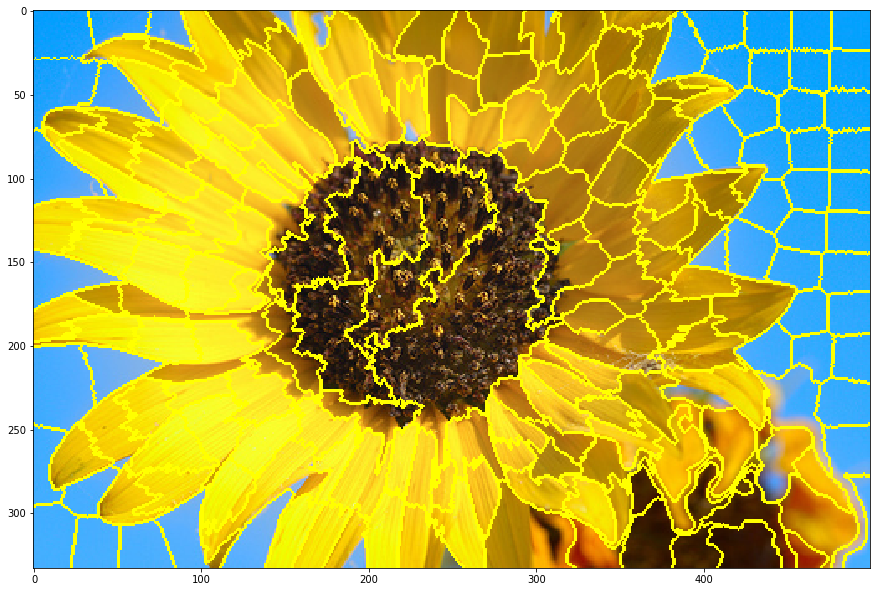

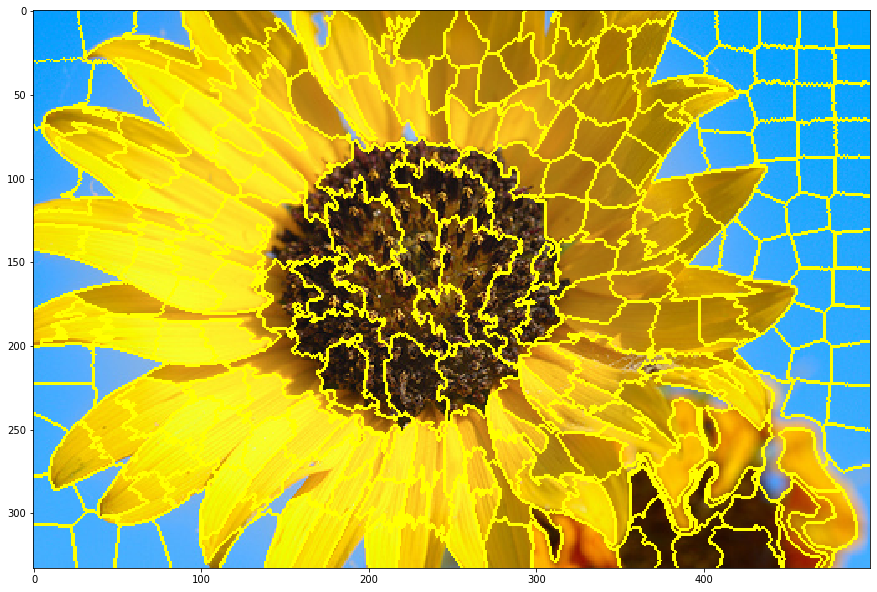

In [1]:
#importamos librerias utiles
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import cv2
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
import pandas as pd
from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

#leemos la imagen entrenamiento y la pasamos a un array del tipo float
lectura = io.imread('texturas2/2.jpg')
imagen = img_as_float(lectura)

#variamos la cantidad aproximada de particiones y las superponemos en la imagen de entrenamiento
for particiones in range(50,400,50):
    segmentada = slic(imagen, n_segments = particiones, sigma=0)
    fig = plt.figure("Superpixels -- %d segments" % (particiones),figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(imagen, segmentada))
    
plt.show()

In [2]:
#trabajamos con 750 superpixeles aproximadamente
ss = slic(imagen, n_segments = 750, sigma=0,convert2lab=True)

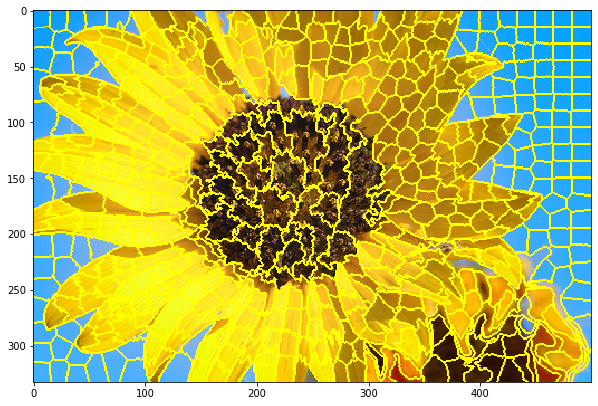

In [3]:
#mostramos la imagen y sus superpixeles con los que vamos a trabajar
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(imagen, ss))

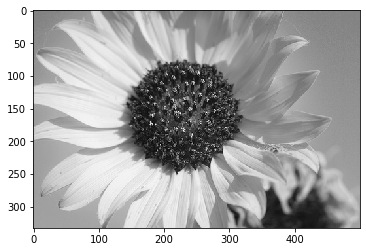

In [4]:
#convertimos a gris
imagenGris = cv2.imread('texturas2/2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imagenGris,cmap='gray')
plt.show()

## Esta parte es de prueba para entender lo que estaba haciendo

In [5]:
z = np.where(ss==530)
z

(array([317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318,
        318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318,
        318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319,
        319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320,
        320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320,
        320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321,
        321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322,
        322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322,
        322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323,
        323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324,
        324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325,
        325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325,
        325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326,
        326, 326, 326, 326, 326, 326, 326, 326, 327

In [6]:
oo = np.zeros((imagenGris.shape),dtype=np.uint8)
oo[z] = 1 
oo = oo*imagenGris

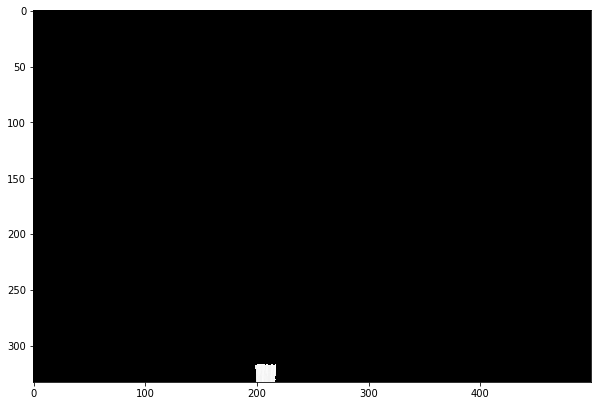

In [7]:
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(oo,cmap='gray')

In [8]:
result = greycomatrix(oo, [1], [0],symmetric=True, normed=True)
#result[:,:,0,0]
e=pd.DataFrame(result[:,:,0,0])
e.to_csv('df.csv')
P = result[1:,1:,:,:]
contrast = greycoprops(P, 'contrast')
contrast

array([[12.49236641]])

## Termina la parte de prueba

In [9]:
#creamos la funcion que obtiene las caracteristicas que come la imagen y el array de superpixeles
#esta funcion regresa los datos de la GLCM para cada superpixel
def caracteristicas(imagen,matrizSlic):
    datos = np.zeros(((np.amax(matrizSlic)),6), dtype=float)
    for particiones in range (np.amax(matrizSlic)+1):
        segmento = np.where(matrizSlic==particiones)
        imagenAuxiliar = np.zeros((imagen.shape),dtype=np.uint8)
        imagenAuxiliar[segmento] = 1
        imagenAuxiliar = imagenAuxiliar*imagen
        GLCM = greycomatrix(imagenAuxiliar, [1], [0],symmetric=True,normed=True)
        GLCM = GLCM[1:,1:,:,:]
        contraste = greycoprops(GLCM, 'contrast')
        disimilitud = greycoprops(GLCM,'dissimilarity')
        homogeneidad = greycoprops(GLCM,'homogeneity')
        asm = greycoprops(GLCM,'ASM')
        energia = greycoprops(GLCM,'energy')
        correlacion = greycoprops(GLCM,'correlation')
        datos[particiones-1]=(contraste,disimilitud,homogeneidad,asm,energia,correlacion)
    return datos

In [10]:
#definimos nuestros conjuntos de entrenamiento
xTrain = caracteristicas(imagenGris,ss)
xTrainEs = preprocessing.scale(xTrain)
yTrain=np.array(list(range(1, np.amax(ss)+1)))

#definimos y entrenamos nuestros clasificadores
neigh = KNeighborsClassifier()
neigh.fit(xTrain, yTrain)
neighEs = KNeighborsClassifier()
neighEs.fit(xTrainEs, yTrain)

maquinaSoporte = svm.SVC(kernel='linear', C=1)
maquinaSoporte.fit(xTrain,yTrain)

maquinaSoporteEs = svm.SVC(kernel='linear', C=1)
maquinaSoporteEs.fit(xTrainEs,yTrain)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

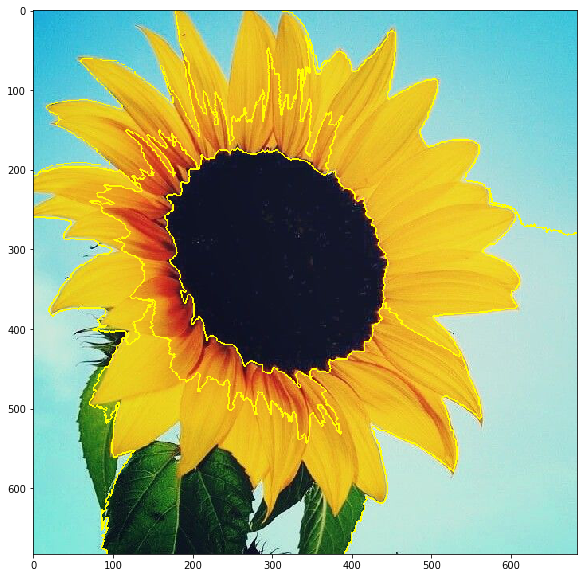

In [11]:
#leemos la imagen de prueba y obtenemos aproximadamente 20 particiones
#mostramos la imagen
lecturavalidacion = io.imread('texturas2/va.jpg')
imagenvalidacion = img_as_float(lecturavalidacion)
ssval = slic(imagenvalidacion, n_segments = 20, sigma=0,convert2lab=True)
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(imagenvalidacion, ssval))

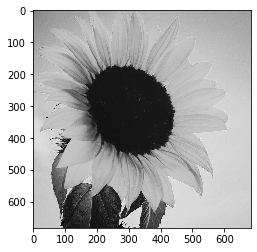

In [12]:
#convertimos a gris la imagen de prueba
imagenValGris = cv2.imread('texturas2/va.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imagenValGris,cmap='gray')
plt.show()

In [13]:
#obtenemos las caracteristicas de la imagen de prueba
xValid = caracteristicas(imagenValGris, ssval)
#escalamos los datos
xValidEs = preprocessing.scale(xValid)

#predecimos los datos de preuba con los clasificadores
kNN = neigh.predict(xValid)
kNNEs = neighEs.predict(xValidEs)
SVM = maquinaSoporte.predict(xValid)
SVMEs= maquinaSoporteEs.predict(xValidEs)

In [14]:
#definimos la funcion que crea la imagen de validacion y pinta la imagen de validacion
#segun la posicion del superpixel y su clase predicha
def creaImagen(Imagen,MatrizSlic,prediccion):
    imagenValid = np.zeros((Imagen.shape),dtype=np.uint8)
    for particiones in range (np.amax(MatrizSlic)+1):
        segmento = np.where(MatrizSlic==particiones)
        imagenAuxiliar = np.zeros((imagen.shape),dtype=np.uint8)
        imagenValid[segmento] = prediccion[particiones-1]
    return imagenValid

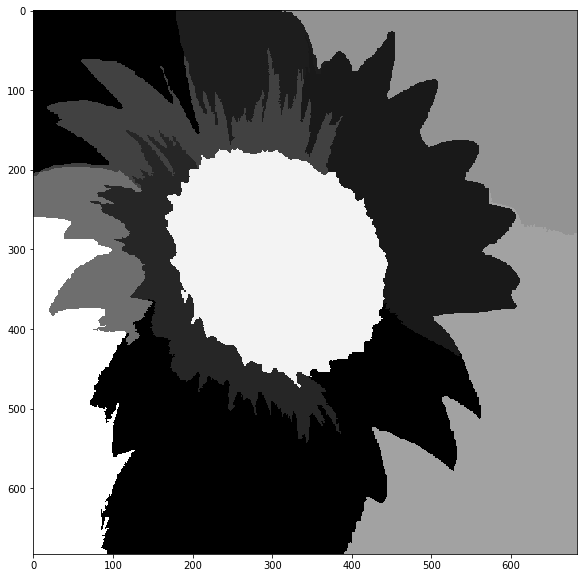

In [15]:
#imagen de validacion para SVM
s = creaImagen(imagenValGris,ssval,SVMEs)
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(s,cmap='gray')

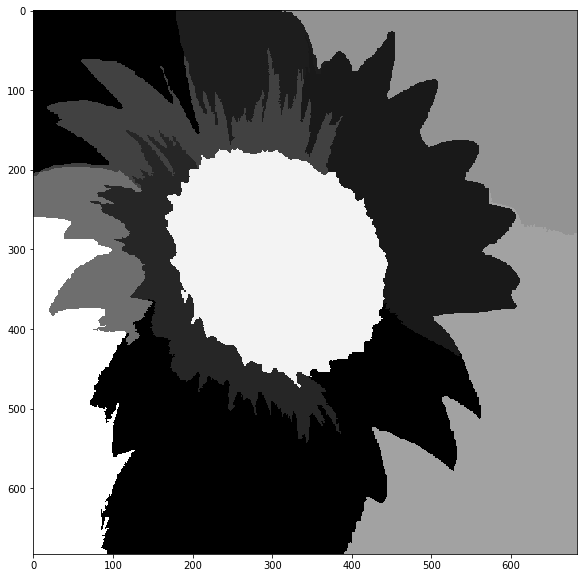

In [16]:
#imagen de validacion para kNN
k = creaImagen(imagenValGris,ssval,kNNEs)
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(s,cmap='gray')

[[ 3.54463881e+00  3.31170616e+00 -1.54633350e+00 -7.12263120e-01
  -1.20890053e+00 -3.75878647e-01]
 [-1.62396546e-01 -1.02617259e-02 -3.85359786e-01 -3.97226754e-01
  -4.27188168e-01  3.19502832e-02]
 [-3.53633414e-01 -6.60475246e-01  1.21874842e+00  1.07406347e+00
   1.24661183e+00  3.13092631e-03]]


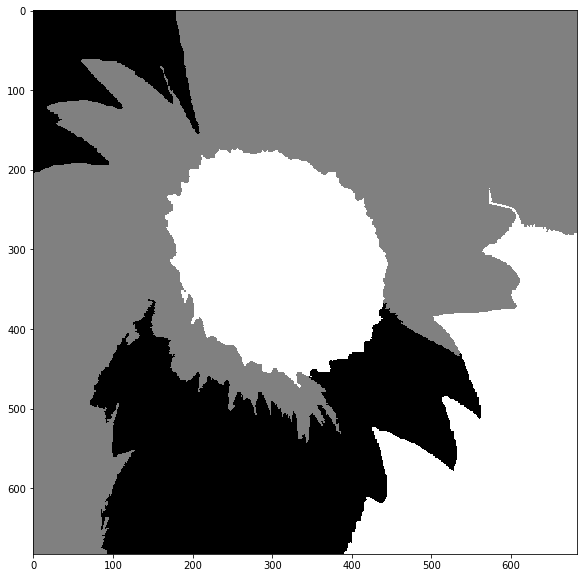

In [17]:
#importamos librerias utiles para k-medias
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#definimos y entrenamos el clasificador k-medias con 3 clusters usando la x escalada definida arriba
kmeans = KMeans(n_clusters=3).fit(xTrainEs)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
#predecimos los datos de prueba
z = kmeans.predict(xValidEs)
#imagen de validacion para k-medias
km = creaImagen(imagenValGris,ssval,z)
fig = plt.figure("Superpixels -- s segments",figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(km,cmap='gray')


## Fin.
documentacion en 10 minutos.